# Incremental Evaluation

## 1 - Load the data

In [4]:
# Imports

import json
import os
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_curve

import matplotlib.pyplot as plt


from compare import *

# Set this to the path where the data is 
DATA_ROOT = '..\openmic-2018'

if not os.path.exists(DATA_ROOT):
    raise ValueError('Did you forget to set `DATA_ROOT`?')


In [5]:
# Loading the data
OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'), allow_pickle=True)

# Make direct variable names for everything
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']


In [6]:
# Map class indices to names
with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:
    class_map = json.load(f)

In [7]:
class_map

{'accordion': 0,
 'banjo': 1,
 'bass': 2,
 'cello': 3,
 'clarinet': 4,
 'cymbals': 5,
 'drums': 6,
 'flute': 7,
 'guitar': 8,
 'mallet_percussion': 9,
 'mandolin': 10,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'synthesizer': 14,
 'trombone': 15,
 'trumpet': 16,
 'ukulele': 17,
 'violin': 18,
 'voice': 19}

## 2 - Load the splits
### Creating splits for train, test, and the unlabeled data.
###### Adapted from the original OpenMIC notebook

In [8]:
# Split the data into train, test, and unlabeled sets
# Use squeeze=True here to return a single array for each, rather than a full DataFrame

split_train = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_train.csv'), 
                          header=None).squeeze("columns")
split_test = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_test.csv'), 
                         header=None).squeeze("columns")

# Create partition CSV for unlabeled
split_unlabeled = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_unlabeled.csv'), 
                         header=None).squeeze("columns")

In [9]:
# The breakdown of the data is roughly 50% training, 25% test, 25% unlabeled
# The percentage breakdowns can be adjusted by adjusting the partitions csv's above 
print('# Train: {},  # Test: {}, # Unlabeled: {}'.format(len(split_train), len(split_test), len(split_unlabeled)))

# Train: 9993,  # Test: 5085, # Unlabeled: 4922


In [10]:
train_set = set(split_train)
test_set = set(split_test)
unlabeled_set = set(split_unlabeled)

In [11]:
# Split the data into arrays

idx_train, idx_test, idx_unlabeled = [], [], []

for idx, n in enumerate(sample_key):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    elif n in unlabeled_set:
        idx_unlabeled.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(sample_key[n]))

# Cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)
idx_unlabeled = np.asarray(idx_unlabeled)

### What's included in the data?

- `X`: 20000 * 10 * 128 array of VGGish features
    - First index (0..19999) corresponds to the sample key
    - Second index (0..9) corresponds to the time within the clip (each time slice is 960 ms long)
    - Third index (0..127) corresponds to the VGGish features at each point in the 10sec clip
    - Example `X[40, 8]` is the 128-dimensional feature vector for the 9th time slice in the 41st example
- `Y_true`: 20000 * 20 array of *true* label probabilities
    - First index corresponds to sample key, as above
    - Second index corresponds to the label class (accordion, ..., voice)
    - Example: `Y[40, 4]` indicates the confidence that example #41 contains the 5th instrument
- `Y_mask`: 20000 * 20 binary mask values
    - First index corresponds to sample key
    - Second index corresponds to the label class
    - Example: `Y[40, 4]` indicates whether or not we have observations for the 5th instrument for example #41
- `sample_key`: 20000 array of sample key strings
    - Example: `sample_key[40]` is the sample key for example #41

In [12]:
# Finally, we use the split indices to partition the features, labels, and masks
X_train = X[idx_train]
X_test = X[idx_test]
X_unlabeled = X[idx_unlabeled]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]
Y_true_unlabeled = Y_true[idx_unlabeled]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]
Y_mask_unlabeled = Y_mask[idx_unlabeled]

In [13]:
# Validate shapes of slices
print(X_train.shape)
print(X_test.shape)
print(X_unlabeled.shape)

(9993, 10, 128)
(5085, 10, 128)
(4922, 10, 128)


## 3 - Fit the models

In [14]:
models = dict()

for instrument in class_map:

    # Map the instrument name to its column number
    inst_num = class_map[instrument]

    rfc = trainModel("rfc",inst_num, X_train, X_test, Y_true_train, Y_true_test, Y_mask_train, Y_mask_test)[0]
    knn = trainModel("knn",inst_num, X_train, X_test, Y_true_train, Y_true_test, Y_mask_train, Y_mask_test)[0]
    
    # Store the classifier in our dictionary
    models[instrument] = [rfc, knn]

## 4 - Algorithmic Disagreement

#### In the algorithimc disagreement process, two models evaluate the same piece of data and their evaluations are compared. If they disagree on their evaluation, that track is deemed to be a priority for annotation.
##### Let's start with an example

In [15]:
# We need soundfile to load audio data
import soundfile as sf

# For audio playback
from IPython.display import Audio

In [16]:
# Run algorithmic disagreement process

# Populate skipIndices with empty arrays to be filled
skipIndices = {}
for i in class_map:
    skipIndices[i] = []


# uncertaintyScores, allPredictions = compare(X_unlabeled, models, skipIndices=skipIndices)

In [17]:
# uncertaintyScores["voice"]

In [18]:
# list(uncertaintyScores["voice"].items())[:5]

In [19]:
# Get ID of the most uncertain track for voice
# highest_idx = list(uncertaintyScores.get("voice").items())[0][0]
# trackID = split_unlabeled[highest_idx]

In [20]:
# And the most uncertain track is...
# trackID

Let's hear what this difficult-to-label track sounds like!

In [21]:
# Replace below .ogg file with trackID
# audio, rate = sf.read(os.path.join(DATA_ROOT, 'audio/027/027639_257280.ogg'))

In [22]:
# Let's listen to the example
# Audio(data=audio.T, rate=rate)

### 5 - Incremental Evaluation -- Simulate the Annotation Process

In [23]:
# First, train a model on the fully annotated dataset. This is what we will be measuring efficiency against. 
combined_models = dict()

for instrument in class_map:

    # get column num from instrument name
    inst_num = class_map[instrument]

    rfc, X_test_inst_sklearn, Y_true_test_inst = trainModel("rfc",inst_num, X_train, X_test, Y_true_train, \
                                                                                  Y_true_test, Y_mask_train, Y_mask_test)
    combined_models[instrument] = rfc


In [24]:
# Constants
NUM_TO_LABEL = 500  # Batch size
NUM_RANDOM = 50      # Number of random tracks to include 
EPOCHS = 10       # Number of times to annotate

# Set Up
skipIndices = {}
accuracies_over_time = {}
ctrl_accuracies = {}
instrProps = {}
reports = {}
recalls = {}
precisions = {}
ctrl_recalls = {}
ctrl_precisions = {}

# Populate dictionaries with instrument keys
for i in class_map:
    skipIndices[i] = []
    accuracies_over_time[i] = []
    ctrl_accuracies[i] = []
    instrProps[i] = []
    reports[i] = []
    recalls[i] = []
    precisions[i] = []
    ctrl_recalls[i] = []
    ctrl_precisions[i] = []

# MAIN LOOP
for i in range(EPOCHS):

    # get instrument predictions
    sorted_trx, allInstProbs = compare(X_unlabeled, models, skipIndices=skipIndices)

    for instr in sorted_trx:    
        X_labeled = []           # Track IDs for labeled tracks
        Y_true_labeled = []      # True values for labeled tracks

        ###########################################################################
        # SELECT TRACKS FOR ANNOTATION

        # Retrieve the top tracks for annotation
        track_indices = list(sorted_trx[instr].items())[:NUM_TO_LABEL]
        track_indices = [i[0] for i in track_indices]   # isolates the indices

        # add random tracks to be annotated to avoid false positives
        # track_indices = addRandomTracks(NUM_RANDOM, len(sorted_trx[instr]), track_indices, allInstProbs[instr])

        # add track IDs to the labeled list
        for trk in track_indices:
            X_labeled.append(X_unlabeled[trk])

            # If the track has not yet been labeled for this instrument, update with avg prediction
            # if Y_true_unlabeled[trk][class_map[instr]] == 0.5:
            #     Y_true_unlabeled[trk][class_map[instr]] = np.average(allInstProbs[instr][trk])
        
            Y_true_labeled.append(Y_true_unlabeled[trk])
            Y_mask_unlabeled[trk][class_map[instr]] = True

        # Update indices to skip here
        skipIndices[instr] = np.append(skipIndices[instr], track_indices)


        
        ###########################################################################
        # TRAIN MODEL ON PARTIALLY ANNOTATED DATASET
        
        inst_num = class_map[instr]

        model, props = trainPartialModel(class_map[instr], X_labeled, Y_true_labeled)
        
        instrProps[instr].append(props)


        ###########################################################################
        # COMPARE ACCURACY WITH FULLY ANNOTATED MODEL

        # Graph the accuracy results
        control_model = combined_models[instr]

        Y_pred_test_ctrl = control_model.predict(X_test_inst_sklearn)
        Y_pred_test_rfc = model.predict(X_test_inst_sklearn)

        rprt = classification_report(Y_true_test_inst, Y_pred_test_rfc, output_dict=True) 
        ctrl_rprt = classification_report(Y_true_test_inst, Y_pred_test_ctrl, output_dict=True)

        acc = rprt["accuracy"]
        ctrl_acc = ctrl_rprt["accuracy"]

        rec = rprt['True']['recall']
        ctrl_rec = ctrl_rprt['True']['recall']

        prec = rprt['True']['precision']
        ctrl_prec = ctrl_rprt['True']['precision']

        # ctrl_rec = ctrl_rprt['recall']

        print(i,":", instr,"Control accuracy:", ctrl_acc, "\tNewly trained accuracy:", acc)

        accuracies_over_time[instr].append(acc)
        ctrl_accuracies[instr].append(ctrl_acc)
        reports[instr].append(rprt)
        recalls[instr].append(rec)
        precisions[instr].append(prec)
        ctrl_recalls[instr].append(ctrl_rec)
        ctrl_precisions[instr].append(ctrl_prec)


accordion starting
accordion finished
banjo starting
banjo finished
bass starting
bass finished
cello starting
cello finished
clarinet starting
clarinet finished
cymbals starting
cymbals finished
drums starting
drums finished
flute starting
flute finished
guitar starting
guitar finished
mallet_percussion starting
mallet_percussion finished
mandolin starting
mandolin finished
organ starting
organ finished
piano starting
piano finished
saxophone starting
saxophone finished
synthesizer starting
synthesizer finished
trombone starting
trombone finished
trumpet starting
trumpet finished
ukulele starting
ukulele finished
violin starting
violin finished
voice starting
voice finished
0 : accordion Control accuracy: 0.4037433155080214 	Newly trained accuracy: 0.3877005347593583


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

0 : banjo Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
0 : bass Control accuracy: 0.38235294117647056 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

0 : cello Control accuracy: 0.35561497326203206 	Newly trained accuracy: 0.40106951871657753
0 : clarinet Control accuracy: 0.40106951871657753 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

0 : cymbals Control accuracy: 0.6336898395721925 	Newly trained accuracy: 0.40106951871657753
0 : drums Control accuracy: 0.732620320855615 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

0 : flute Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
0 : guitar Control accuracy: 0.45187165775401067 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

0 : mallet_percussion Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.40106951871657753
0 : mandolin Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

0 : organ Control accuracy: 0.39037433155080214 	Newly trained accuracy: 0.40106951871657753
0 : piano Control accuracy: 0.33689839572192515 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

0 : saxophone Control accuracy: 0.3983957219251337 	Newly trained accuracy: 0.40106951871657753
0 : synthesizer Control accuracy: 0.28609625668449196 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

0 : trombone Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
0 : trumpet Control accuracy: 0.4144385026737968 	Newly trained accuracy: 0.3983957219251337


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

0 : ukulele Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
0 : violin Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

0 : voice Control accuracy: 0.9197860962566845 	Newly trained accuracy: 0.40106951871657753
accordion starting
accordion finished
banjo starting
banjo finished
bass starting
bass finished
cello starting
cello finished
clarinet starting
clarinet finished
cymbals starting
cymbals finished
drums starting
drums finished
flute starting
flute finished
guitar starting
guitar finished
mallet_percussion starting
mallet_percussion finished
mandolin starting
mandolin finished
organ starting
organ finished
piano starting
piano finished
saxophone starting
saxophone finished
synthesizer starting
synthesizer finished
trombone starting
trombone finished
trumpet starting
trumpet finished
ukulele starting
ukulele finished
violin starting
violin finished
voice starting
voice finished


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

1 : accordion Control accuracy: 0.4037433155080214 	Newly trained accuracy: 0.40106951871657753
1 : banjo Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
1 : bass Control accuracy: 0.38235294117647056 	Newly trained accuracy: 0.3983957219251337
1 : cello Control accuracy: 0.35561497326203206 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

1 : clarinet Control accuracy: 0.40106951871657753 	Newly trained accuracy: 0.40106951871657753
1 : cymbals Control accuracy: 0.6336898395721925 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

1 : drums Control accuracy: 0.732620320855615 	Newly trained accuracy: 0.40106951871657753
1 : flute Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

1 : guitar Control accuracy: 0.45187165775401067 	Newly trained accuracy: 0.40106951871657753
1 : mallet_percussion Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

1 : mandolin Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.40106951871657753
1 : organ Control accuracy: 0.39037433155080214 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

1 : piano Control accuracy: 0.33689839572192515 	Newly trained accuracy: 0.40106951871657753
1 : saxophone Control accuracy: 0.3983957219251337 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

1 : synthesizer Control accuracy: 0.28609625668449196 	Newly trained accuracy: 0.40106951871657753
1 : trombone Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

1 : trumpet Control accuracy: 0.4144385026737968 	Newly trained accuracy: 0.40106951871657753
1 : ukulele Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.3983957219251337


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

1 : violin Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
1 : voice Control accuracy: 0.9197860962566845 	Newly trained accuracy: 0.4090909090909091
accordion starting
accordion finished
banjo starting
banjo finished
bass starting
bass finished
cello starting
cello finished
clarinet starting
clarinet finished
cymbals starting
cymbals finished
drums starting
drums finished
flute starting
flute finished
guitar starting
guitar finished
mallet_percussion starting
mallet_percussion finished
mandolin starting
mandolin finished
organ starting
organ finished
piano starting
piano finished
saxophone starting
saxophone finished
synthesizer starting
synthesizer finished
trombone starting
trombone finished
trumpet starting
trumpet finished
ukulele starting
ukulele finished
violin starting
violin finished
voice starting
voice finished
2 : accordion Control accuracy: 0.4037433155080214 	Newly trained accuracy: 0.39037433155080214


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

2 : banjo Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
2 : bass Control accuracy: 0.38235294117647056 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

2 : cello Control accuracy: 0.35561497326203206 	Newly trained accuracy: 0.40106951871657753
2 : clarinet Control accuracy: 0.40106951871657753 	Newly trained accuracy: 0.40106951871657753
2 : cymbals Control accuracy: 0.6336898395721925 	Newly trained accuracy: 0.39572192513368987
2 : drums Control accuracy: 0.732620320855615 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

2 : flute Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
2 : guitar Control accuracy: 0.45187165775401067 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

2 : mallet_percussion Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.3983957219251337
2 : mandolin Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

2 : organ Control accuracy: 0.39037433155080214 	Newly trained accuracy: 0.40106951871657753
2 : piano Control accuracy: 0.33689839572192515 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

2 : saxophone Control accuracy: 0.3983957219251337 	Newly trained accuracy: 0.3983957219251337
2 : synthesizer Control accuracy: 0.28609625668449196 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

2 : trombone Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
2 : trumpet Control accuracy: 0.4144385026737968 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

2 : ukulele Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
2 : violin Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.37967914438502676
2 : voice Control accuracy: 0.9197860962566845 	Newly trained accuracy: 0.40641711229946526
accordion starting
accordion finished
banjo starting
banjo finished
bass starting
bass finished
cello starting
cello finished
clarinet starting
clarinet finished
cymbals starting
cymbals finished
drums starting
drums finished
flute starting
flute finished
guitar starting
guitar finished
mallet_percussion starting
mallet_percussion finished
mandolin starting
mandolin finished
organ starting
organ finished
piano starting
piano finished
saxophone starting
saxophone finished
synthesizer starting
synthesizer finished
trombone starting
trombone finished
trumpet starting
trumpet finished
ukulele starting
ukulele finished
violin starting
violin finished
voice starting
voice finished


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

3 : accordion Control accuracy: 0.4037433155080214 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3 : banjo Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
3 : bass Control accuracy: 0.38235294117647056 	Newly trained accuracy: 0.3983957219251337


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

3 : cello Control accuracy: 0.35561497326203206 	Newly trained accuracy: 0.40106951871657753
3 : clarinet Control accuracy: 0.40106951871657753 	Newly trained accuracy: 0.40106951871657753
3 : cymbals Control accuracy: 0.6336898395721925 	Newly trained accuracy: 0.393048128342246
3 : drums Control accuracy: 0.732620320855615 	Newly trained accuracy: 0.3983957219251337


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

3 : flute Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
3 : guitar Control accuracy: 0.45187165775401067 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

3 : mallet_percussion Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.40106951871657753
3 : mandolin Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.39572192513368987


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

3 : organ Control accuracy: 0.39037433155080214 	Newly trained accuracy: 0.40106951871657753
3 : piano Control accuracy: 0.33689839572192515 	Newly trained accuracy: 0.40106951871657753
3 : saxophone Control accuracy: 0.3983957219251337 	Newly trained accuracy: 0.3983957219251337
3 : synthesizer Control accuracy: 0.28609625668449196 	Newly trained accuracy: 0.3877005347593583


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

3 : trombone Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
3 : trumpet Control accuracy: 0.4144385026737968 	Newly trained accuracy: 0.3983957219251337


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

3 : ukulele Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
3 : violin Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.3983957219251337
3 : voice Control accuracy: 0.9197860962566845 	Newly trained accuracy: 0.4144385026737968
accordion starting
accordion finished
banjo starting
banjo finished
bass starting
bass finished
cello starting
cello finished
clarinet starting
clarinet finished
cymbals starting
cymbals finished
drums starting
drums finished
flute starting
flute finished
guitar starting
guitar finished
mallet_percussion starting
mallet_percussion finished
mandolin starting
mandolin finished
organ starting
organ finished
piano starting
piano finished
saxophone starting
saxophone finished
synthesizer starting
synthesizer finished
trombone starting
trombone finished
trumpet starting
trumpet finished
ukulele starting
ukulele finished
violin starting
violin finished
voice starting
voice finished
4 : accordion Control accuracy: 0.403743

C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

4 : banjo Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
4 : bass Control accuracy: 0.38235294117647056 	Newly trained accuracy: 0.3983957219251337
4 : cello Control accuracy: 0.35561497326203206 	Newly trained accuracy: 0.3983957219251337
4 : clarinet Control accuracy: 0.40106951871657753 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

4 : cymbals Control accuracy: 0.6336898395721925 	Newly trained accuracy: 0.40106951871657753
4 : drums Control accuracy: 0.732620320855615 	Newly trained accuracy: 0.393048128342246


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

4 : flute Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
4 : guitar Control accuracy: 0.45187165775401067 	Newly trained accuracy: 0.39037433155080214
4 : mallet_percussion Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.39037433155080214
4 : mandolin Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

4 : organ Control accuracy: 0.39037433155080214 	Newly trained accuracy: 0.40106951871657753
4 : piano Control accuracy: 0.33689839572192515 	Newly trained accuracy: 0.393048128342246
4 : saxophone Control accuracy: 0.3983957219251337 	Newly trained accuracy: 0.3983957219251337
4 : synthesizer Control accuracy: 0.28609625668449196 	Newly trained accuracy: 0.3983957219251337
4 : trombone Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.4037433155080214
4 : trumpet Control accuracy: 0.4144385026737968 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

4 : ukulele Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
4 : violin Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.3850267379679144
4 : voice Control accuracy: 0.9197860962566845 	Newly trained accuracy: 0.4037433155080214
accordion starting
accordion finished
banjo starting
banjo finished
bass starting
bass finished
cello starting
cello finished
clarinet starting
clarinet finished
cymbals starting
cymbals finished
drums starting
drums finished
flute starting
flute finished
guitar starting
guitar finished
mallet_percussion starting
mallet_percussion finished
mandolin starting
mandolin finished
organ starting
organ finished
piano starting
piano finished
saxophone starting
saxophone finished
synthesizer starting
synthesizer finished
trombone starting
trombone finished
trumpet starting
trumpet finished
ukulele starting
ukulele finished
violin starting
violin finished
voice starting
voice finished
5 : accordion Control accuracy: 0.403743

C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

5 : banjo Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
5 : bass Control accuracy: 0.38235294117647056 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

5 : cello Control accuracy: 0.35561497326203206 	Newly trained accuracy: 0.40106951871657753
5 : clarinet Control accuracy: 0.40106951871657753 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

5 : cymbals Control accuracy: 0.6336898395721925 	Newly trained accuracy: 0.3689839572192513
5 : drums Control accuracy: 0.732620320855615 	Newly trained accuracy: 0.37433155080213903


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

5 : flute Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
5 : guitar Control accuracy: 0.45187165775401067 	Newly trained accuracy: 0.3877005347593583
5 : mallet_percussion Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.3983957219251337
5 : mandolin Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.39037433155080214


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

5 : organ Control accuracy: 0.39037433155080214 	Newly trained accuracy: 0.40106951871657753
5 : piano Control accuracy: 0.33689839572192515 	Newly trained accuracy: 0.40106951871657753
5 : saxophone Control accuracy: 0.3983957219251337 	Newly trained accuracy: 0.3983957219251337
5 : synthesizer Control accuracy: 0.28609625668449196 	Newly trained accuracy: 0.3449197860962567


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

5 : trombone Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
5 : trumpet Control accuracy: 0.4144385026737968 	Newly trained accuracy: 0.40106951871657753
5 : ukulele Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.3983957219251337
5 : violin Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.37433155080213903
5 : voice Control accuracy: 0.9197860962566845 	Newly trained accuracy: 0.6363636363636364
accordion starting
accordion finished
banjo starting
banjo finished
bass starting
bass finished
cello starting
cello finished
clarinet starting
clarinet finished
cymbals starting
cymbals finished
drums starting
drums finished
flute starting
flute finished
guitar starting
guitar finished
mallet_percussion starting
mallet_percussion finished
mandolin starting
mandolin finished
organ starting
organ finished
piano starting
piano finished
saxophone starting
saxophone finished
synthesizer starting
synthesizer finished
trombone starting

C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

6 : banjo Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
6 : bass Control accuracy: 0.38235294117647056 	Newly trained accuracy: 0.3983957219251337


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

6 : cello Control accuracy: 0.35561497326203206 	Newly trained accuracy: 0.40106951871657753
6 : clarinet Control accuracy: 0.40106951871657753 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

6 : cymbals Control accuracy: 0.6336898395721925 	Newly trained accuracy: 0.40106951871657753
6 : drums Control accuracy: 0.732620320855615 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

6 : flute Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
6 : guitar Control accuracy: 0.45187165775401067 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

6 : mallet_percussion Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.40106951871657753
6 : mandolin Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

6 : organ Control accuracy: 0.39037433155080214 	Newly trained accuracy: 0.40106951871657753
6 : piano Control accuracy: 0.33689839572192515 	Newly trained accuracy: 0.393048128342246
6 : saxophone Control accuracy: 0.3983957219251337 	Newly trained accuracy: 0.3983957219251337
6 : synthesizer Control accuracy: 0.28609625668449196 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

6 : trombone Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
6 : trumpet Control accuracy: 0.4144385026737968 	Newly trained accuracy: 0.39572192513368987


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

6 : ukulele Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
6 : violin Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.393048128342246


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

6 : voice Control accuracy: 0.9197860962566845 	Newly trained accuracy: 0.40106951871657753
accordion starting
accordion finished
banjo starting
banjo finished
bass starting
bass finished
cello starting
cello finished
clarinet starting
clarinet finished
cymbals starting
cymbals finished
drums starting
drums finished
flute starting
flute finished
guitar starting
guitar finished
mallet_percussion starting
mallet_percussion finished
mandolin starting
mandolin finished
organ starting
organ finished
piano starting
piano finished
saxophone starting
saxophone finished
synthesizer starting
synthesizer finished
trombone starting
trombone finished
trumpet starting
trumpet finished
ukulele starting
ukulele finished
violin starting
violin finished
voice starting
voice finished


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

7 : accordion Control accuracy: 0.4037433155080214 	Newly trained accuracy: 0.40106951871657753
7 : banjo Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

7 : bass Control accuracy: 0.38235294117647056 	Newly trained accuracy: 0.40106951871657753
7 : cello Control accuracy: 0.35561497326203206 	Newly trained accuracy: 0.3983957219251337


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

7 : clarinet Control accuracy: 0.40106951871657753 	Newly trained accuracy: 0.40106951871657753
7 : cymbals Control accuracy: 0.6336898395721925 	Newly trained accuracy: 0.3689839572192513
7 : drums Control accuracy: 0.732620320855615 	Newly trained accuracy: 0.37433155080213903
7 : flute Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

7 : guitar Control accuracy: 0.45187165775401067 	Newly trained accuracy: 0.37433155080213903
7 : mallet_percussion Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.393048128342246


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

7 : mandolin Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.40106951871657753
7 : organ Control accuracy: 0.39037433155080214 	Newly trained accuracy: 0.40106951871657753
7 : piano Control accuracy: 0.33689839572192515 	Newly trained accuracy: 0.39037433155080214
7 : saxophone Control accuracy: 0.3983957219251337 	Newly trained accuracy: 0.39572192513368987
7 : synthesizer Control accuracy: 0.28609625668449196 	Newly trained accuracy: 0.3315508021390374
7 : trombone Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

7 : trumpet Control accuracy: 0.4144385026737968 	Newly trained accuracy: 0.40106951871657753
7 : ukulele Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

7 : violin Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.37433155080213903
7 : voice Control accuracy: 0.9197860962566845 	Newly trained accuracy: 0.6283422459893048
accordion starting
accordion finished
banjo starting
banjo finished
bass starting
bass finished
cello starting
cello finished
clarinet starting
clarinet finished
cymbals starting
cymbals finished
drums starting
drums finished
flute starting
flute finished
guitar starting
guitar finished
mallet_percussion starting
mallet_percussion finished
mandolin starting
mandolin finished
organ starting
organ finished
piano starting
piano finished
saxophone starting
saxophone finished
synthesizer starting
synthesizer finished
trombone starting
trombone finished
trumpet starting
trumpet finished
ukulele starting
ukulele finished
violin starting
violin finished
voice starting
voice finished
8 : accordion Control accuracy: 0.4037433155080214 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

8 : banjo Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
8 : bass Control accuracy: 0.38235294117647056 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

8 : cello Control accuracy: 0.35561497326203206 	Newly trained accuracy: 0.40106951871657753
8 : clarinet Control accuracy: 0.40106951871657753 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

8 : cymbals Control accuracy: 0.6336898395721925 	Newly trained accuracy: 0.37433155080213903
8 : drums Control accuracy: 0.732620320855615 	Newly trained accuracy: 0.37967914438502676


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

8 : flute Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
8 : guitar Control accuracy: 0.45187165775401067 	Newly trained accuracy: 0.37433155080213903
8 : mallet_percussion Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.39572192513368987
8 : mandolin Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.39572192513368987


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

8 : organ Control accuracy: 0.39037433155080214 	Newly trained accuracy: 0.40106951871657753
8 : piano Control accuracy: 0.33689839572192515 	Newly trained accuracy: 0.393048128342246
8 : saxophone Control accuracy: 0.3983957219251337 	Newly trained accuracy: 0.39572192513368987
8 : synthesizer Control accuracy: 0.28609625668449196 	Newly trained accuracy: 0.3074866310160428


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

8 : trombone Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
8 : trumpet Control accuracy: 0.4144385026737968 	Newly trained accuracy: 0.3983957219251337


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

8 : ukulele Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
8 : violin Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.3716577540106952
8 : voice Control accuracy: 0.9197860962566845 	Newly trained accuracy: 0.7192513368983957
accordion starting
accordion finished
banjo starting
banjo finished
bass starting
bass finished
cello starting
cello finished
clarinet starting
clarinet finished
cymbals starting
cymbals finished
drums starting
drums finished
flute starting
flute finished
guitar starting
guitar finished
mallet_percussion starting
mallet_percussion finished
mandolin starting
mandolin finished
organ starting
organ finished
piano starting
piano finished
saxophone starting
saxophone finished
synthesizer starting
synthesizer finished
trombone starting
trombone finished
trumpet starting
trumpet finished
ukulele starting
ukulele finished
violin starting
violin finished
voice starting
voice finished
9 : accordion Control accuracy: 0.403743

C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

9 : banjo Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753
9 : bass Control accuracy: 0.38235294117647056 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

9 : cello Control accuracy: 0.35561497326203206 	Newly trained accuracy: 0.40106951871657753
9 : clarinet Control accuracy: 0.40106951871657753 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

9 : cymbals Control accuracy: 0.6336898395721925 	Newly trained accuracy: 0.40106951871657753
9 : drums Control accuracy: 0.732620320855615 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

9 : flute Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.3983957219251337
9 : guitar Control accuracy: 0.45187165775401067 	Newly trained accuracy: 0.3502673796791444


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

9 : mallet_percussion Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.40106951871657753
9 : mandolin Control accuracy: 0.3716577540106952 	Newly trained accuracy: 0.3877005347593583


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

9 : organ Control accuracy: 0.39037433155080214 	Newly trained accuracy: 0.40106951871657753
9 : piano Control accuracy: 0.33689839572192515 	Newly trained accuracy: 0.39037433155080214
9 : saxophone Control accuracy: 0.3983957219251337 	Newly trained accuracy: 0.3983957219251337
9 : synthesizer Control accuracy: 0.28609625668449196 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

9 : trombone Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.40106951871657753


C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Seby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U

9 : trumpet Control accuracy: 0.4144385026737968 	Newly trained accuracy: 0.40106951871657753
9 : ukulele Control accuracy: 0.393048128342246 	Newly trained accuracy: 0.40106951871657753
9 : violin Control accuracy: 0.3877005347593583 	Newly trained accuracy: 0.39572192513368987
9 : voice Control accuracy: 0.9197860962566845 	Newly trained accuracy: 0.40641711229946526


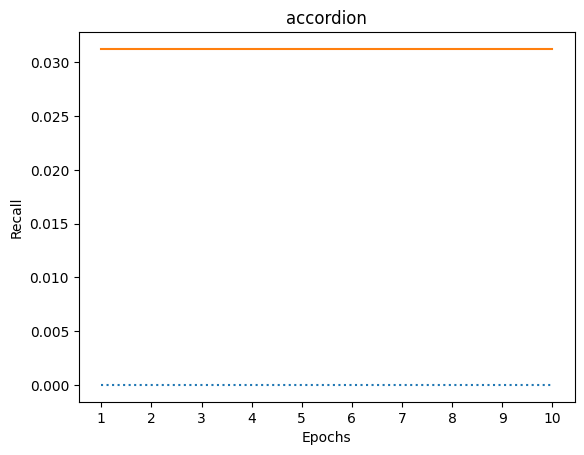

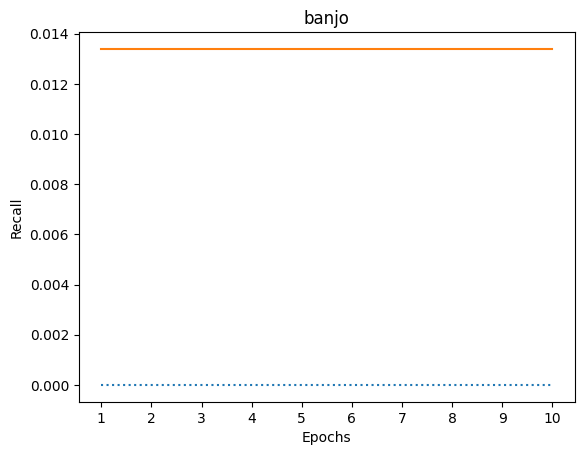

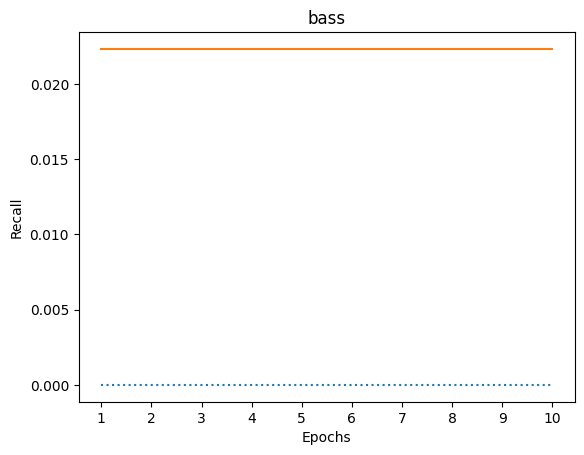

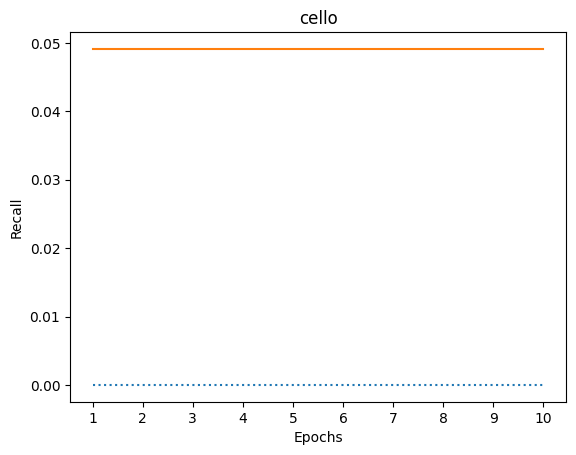

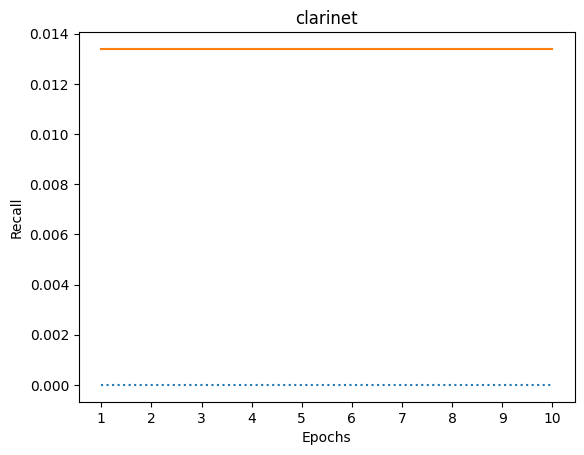

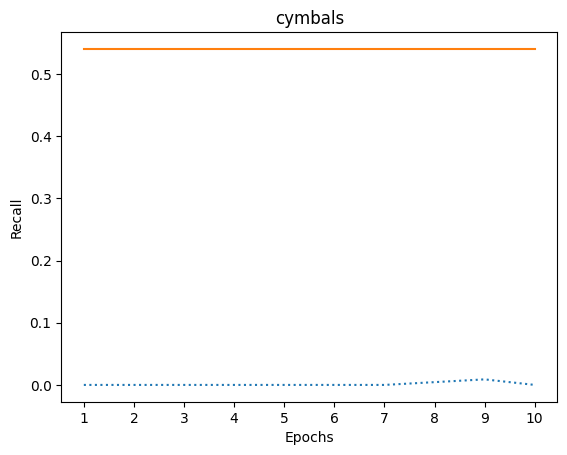

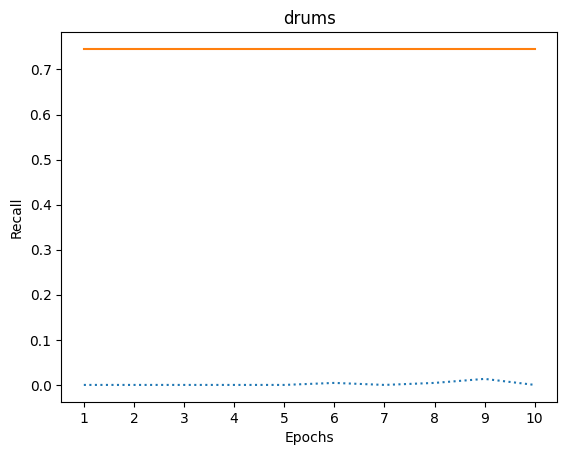

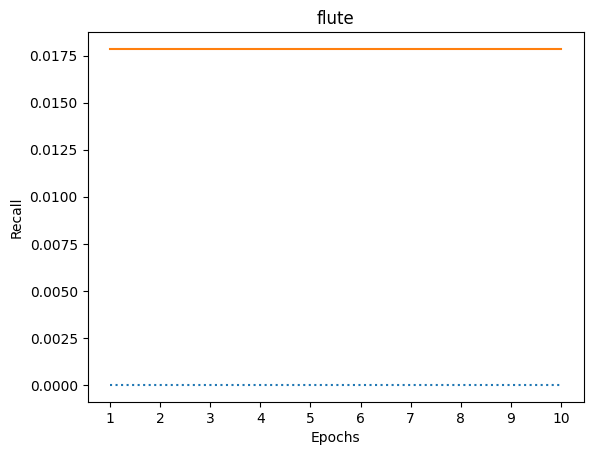

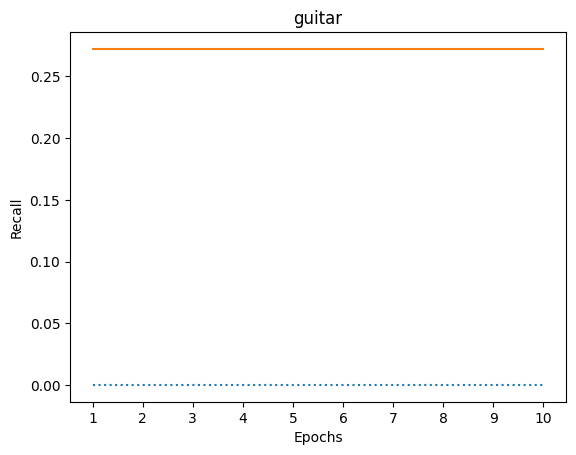

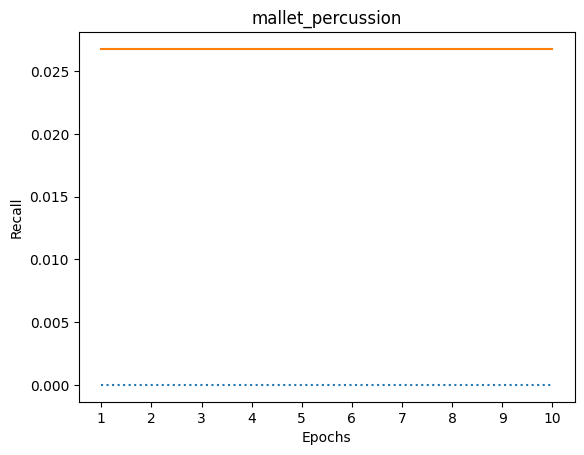

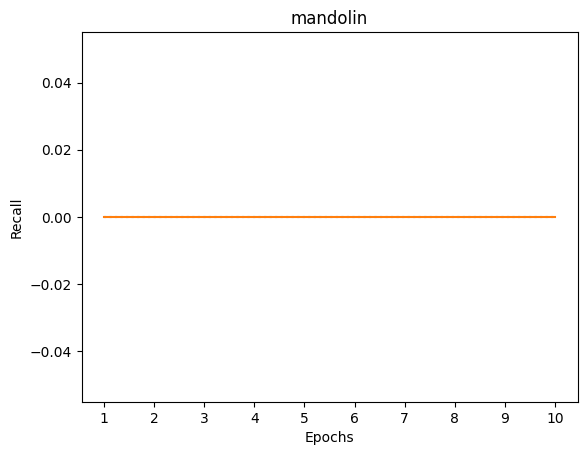

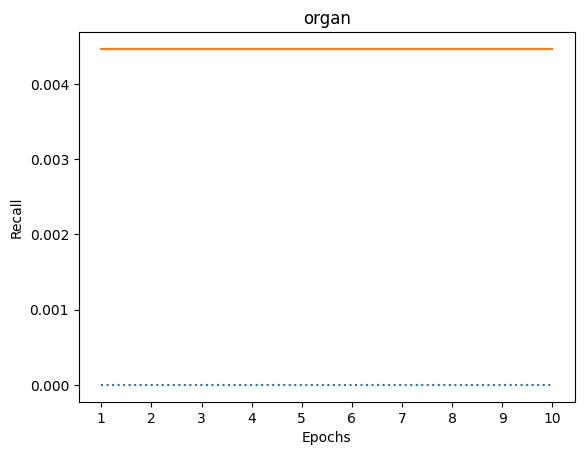

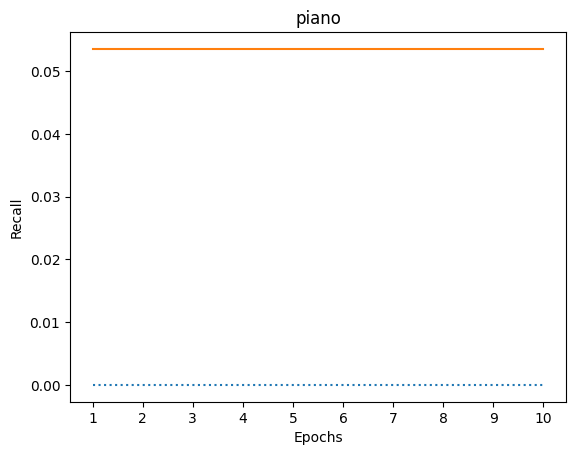

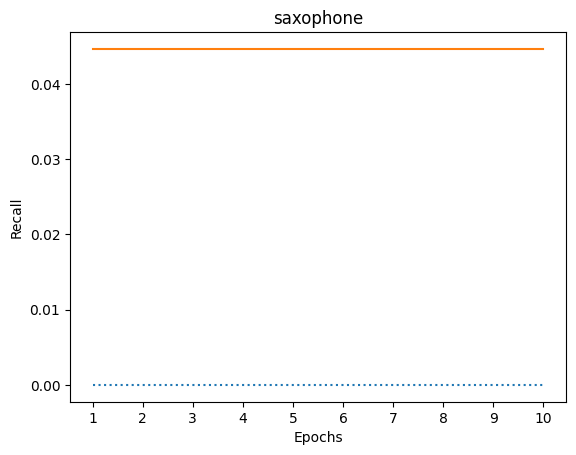

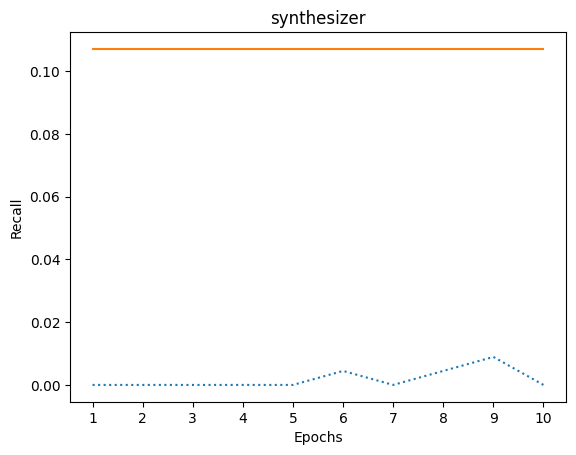

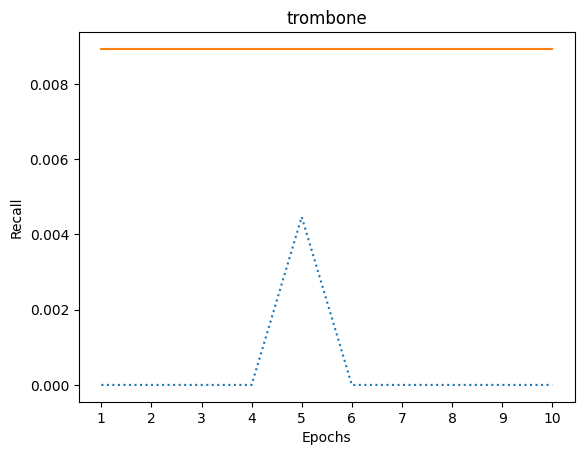

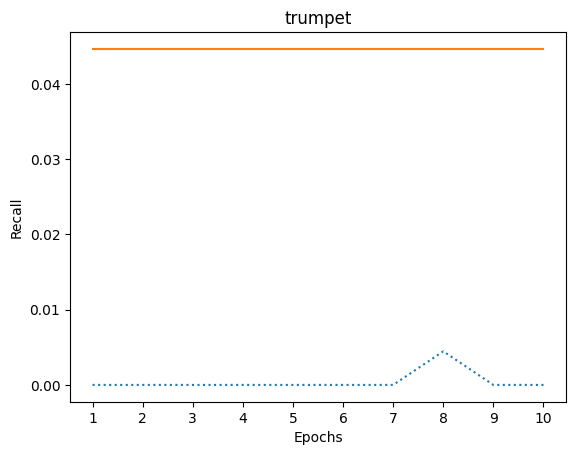

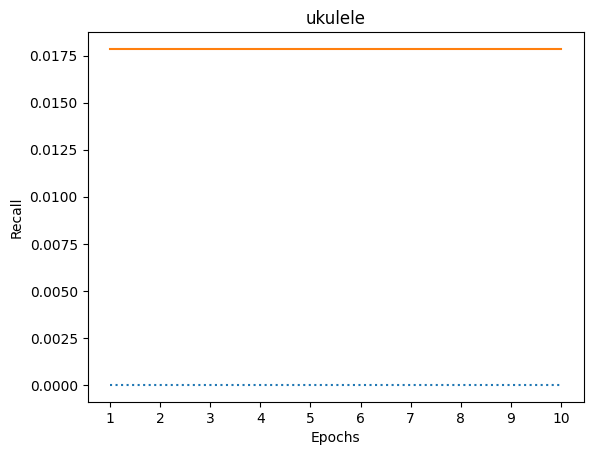

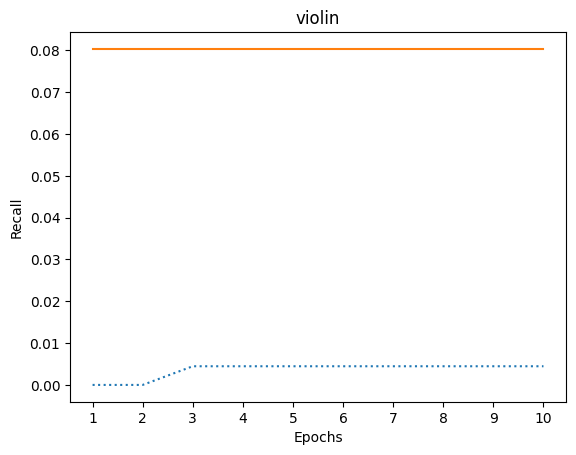

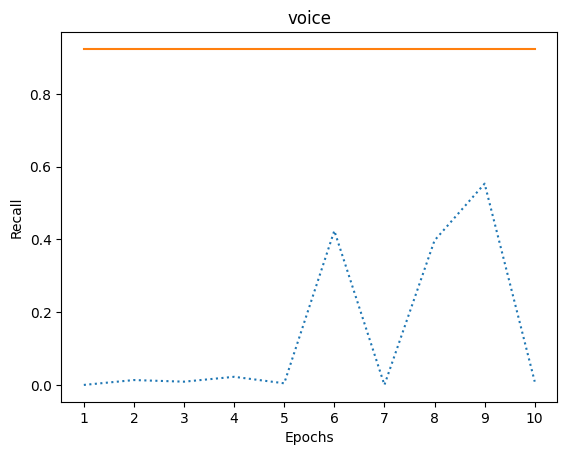

In [25]:
for i in class_map:
    plt.plot(recalls[i], linestyle='dotted')
    plt.plot(ctrl_recalls[i])
    plt.xlabel("Epochs")
    plt.xticks(np.arange(len(recalls[i])), np.arange(1, len(recalls[i])+1))
    plt.ylabel("Recall")
    plt.title(i)
    plt.show()

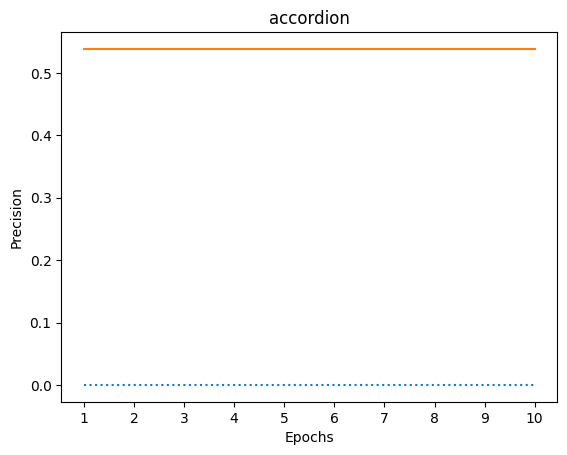

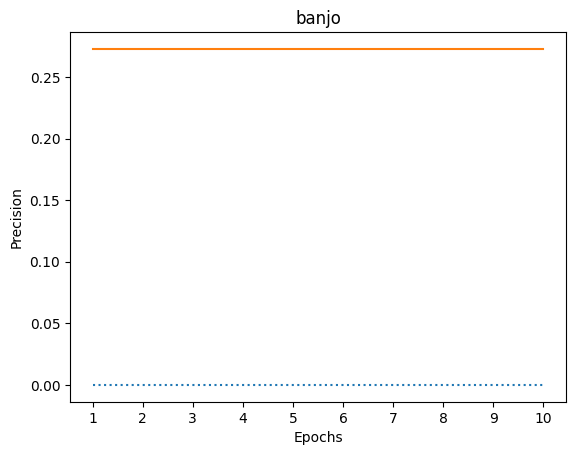

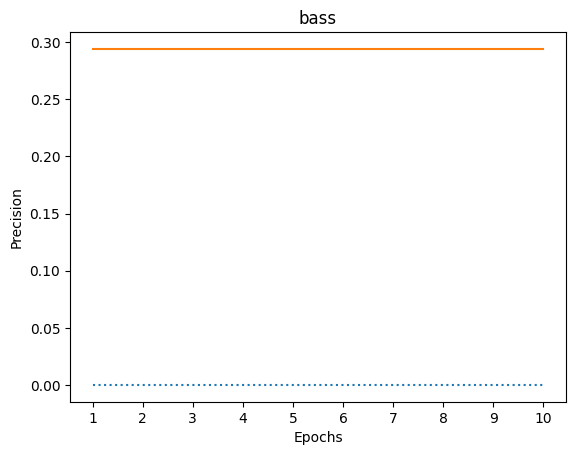

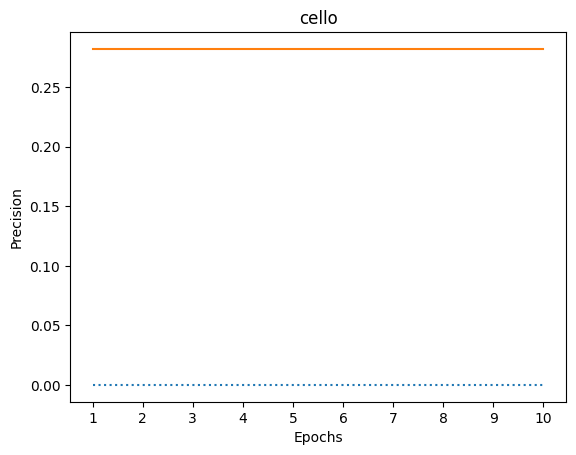

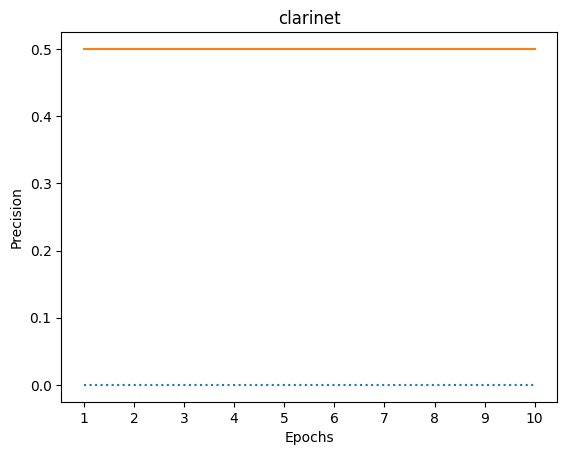

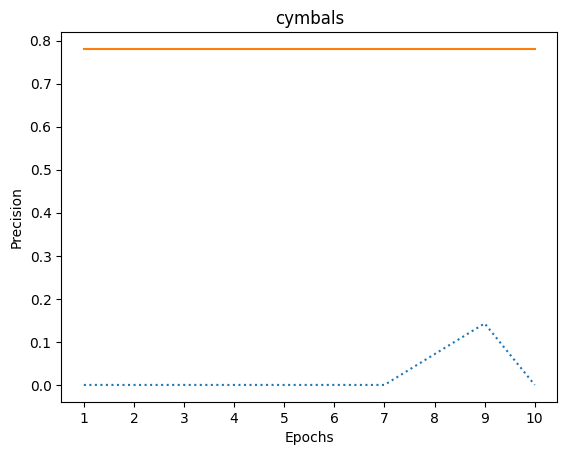

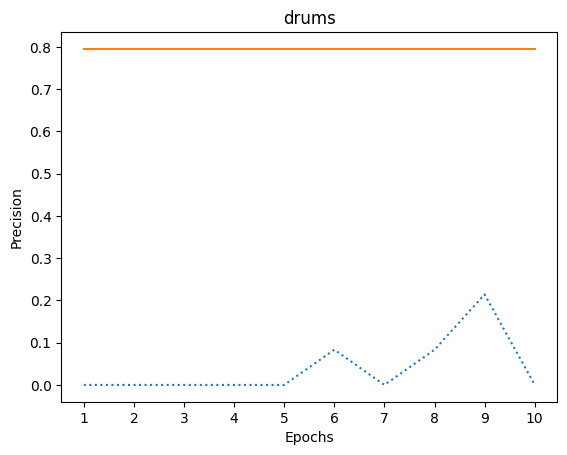

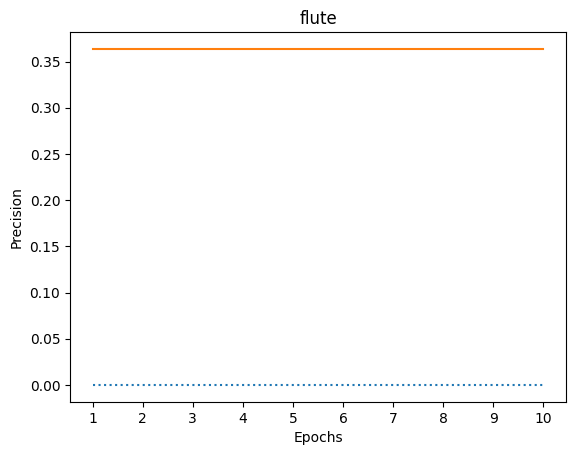

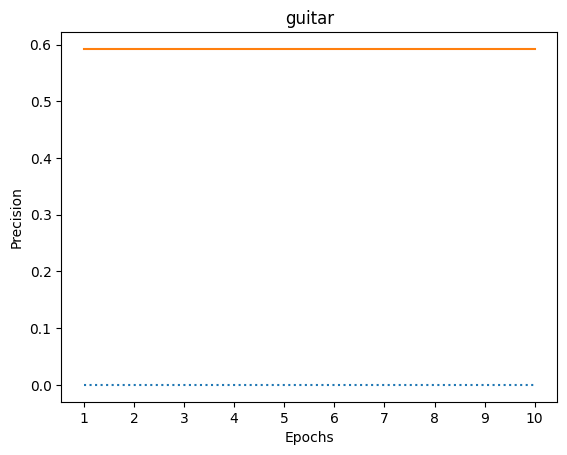

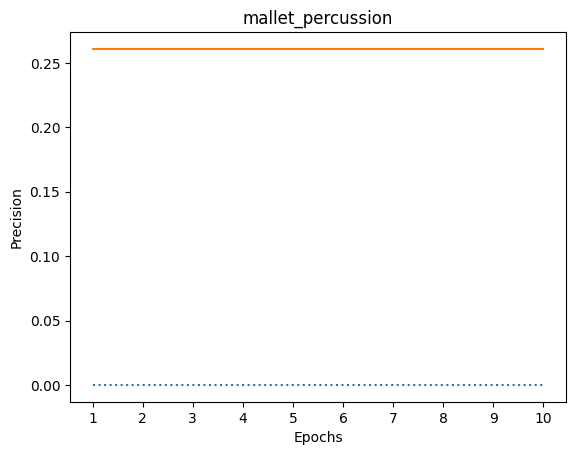

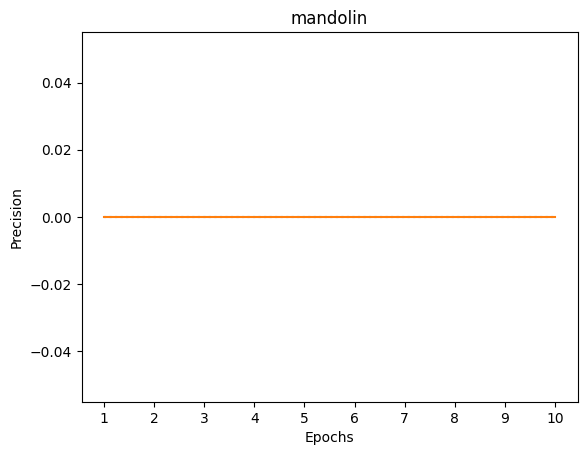

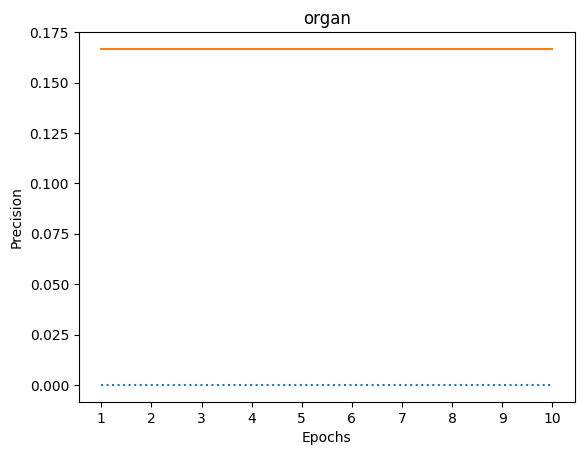

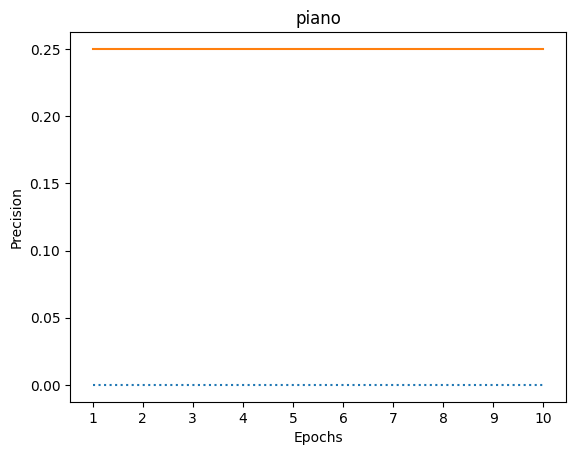

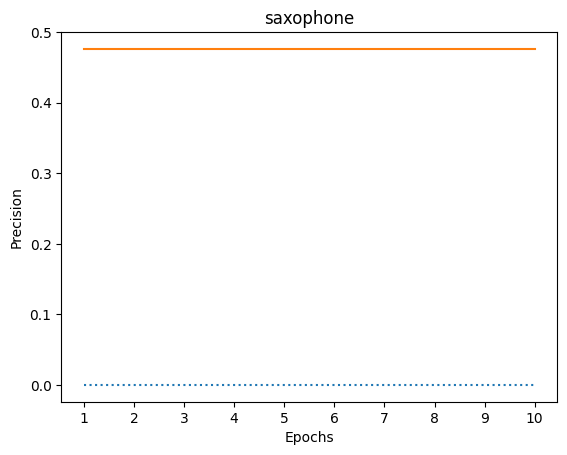

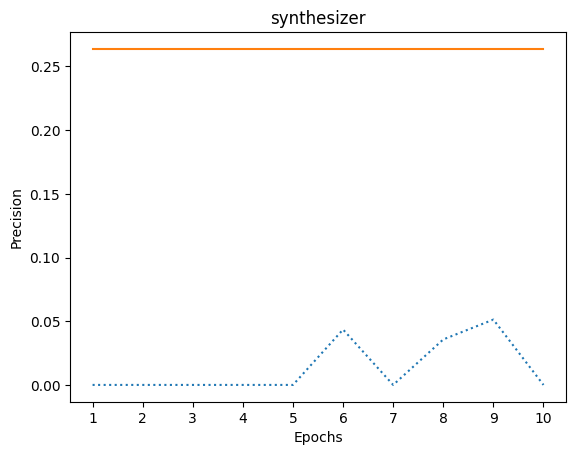

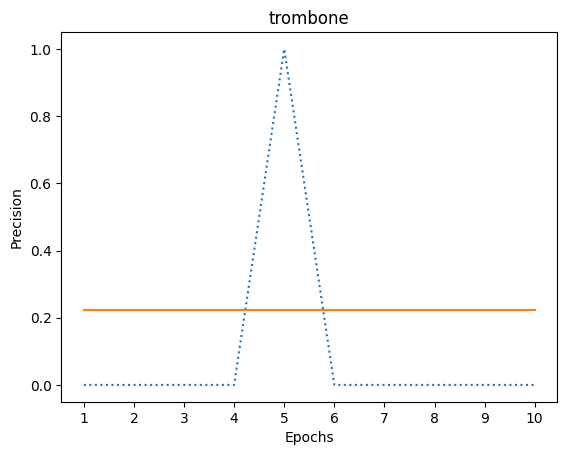

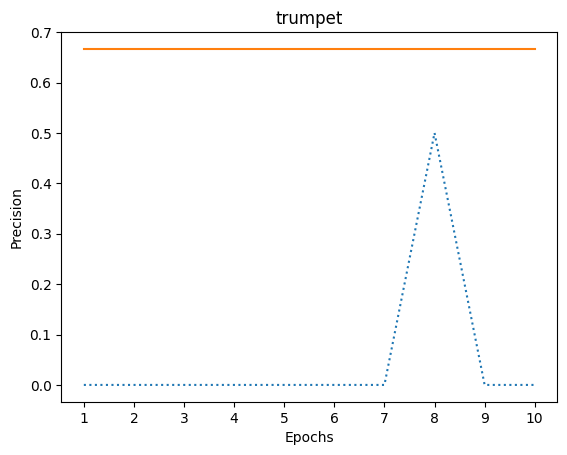

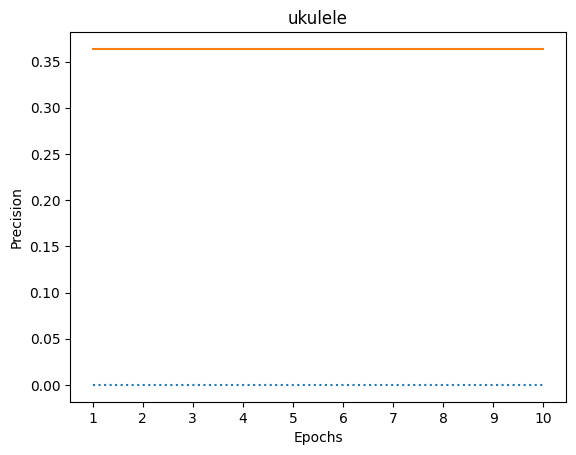

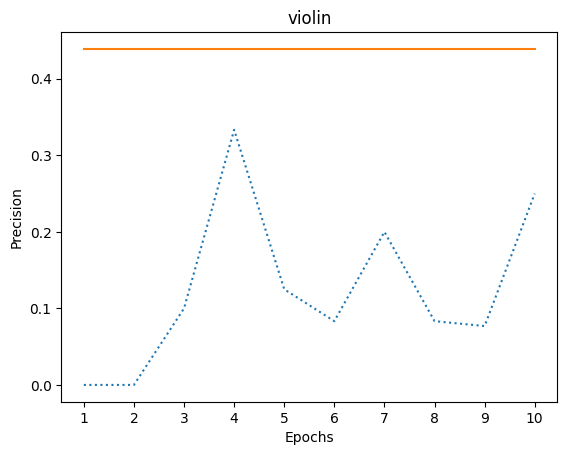

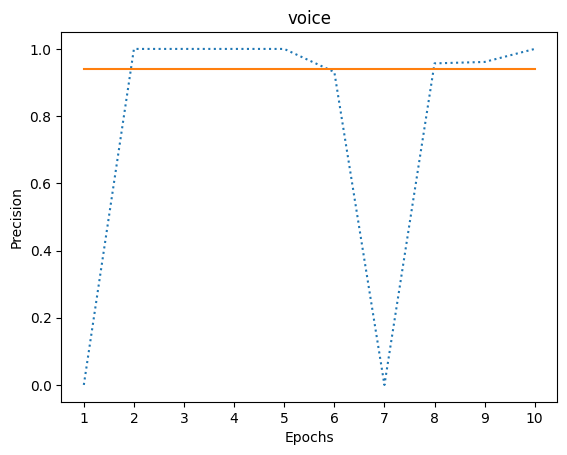

In [26]:
for i in class_map:
    plt.plot(precisions[i], linestyle='dotted')
    plt.plot(ctrl_precisions[i])
    plt.xlabel("Epochs")
    plt.xticks(np.arange(len(precisions[i])), np.arange(1, len(precisions[i])+1))
    plt.ylabel("Precision")
    plt.title(i)
    plt.show()

# Graph the results

In [27]:
for m in class_map:
    print(m,"\t", instrProps[m])

accordion 	 [[500, 32], [500, 13], [500, 23], [500, 23], [500, 5], [500, 11], [500, 14], [500, 14], [500, 6], [422, 2]]
banjo 	 [[500, 42], [500, 41], [500, 25], [500, 46], [500, 26], [500, 17], [500, 21], [500, 36], [500, 13], [422, 4]]
bass 	 [[500, 8], [500, 13], [500, 16], [500, 13], [500, 26], [500, 9], [500, 12], [500, 22], [500, 16], [422, 6]]
cello 	 [[500, 4], [500, 18], [500, 17], [500, 26], [500, 21], [500, 11], [500, 9], [500, 24], [500, 20], [422, 6]]
clarinet 	 [[500, 22], [500, 15], [500, 16], [500, 16], [500, 11], [500, 16], [500, 12], [500, 17], [500, 8], [422, 8]]
cymbals 	 [[500, 0], [500, 6], [500, 10], [500, 16], [500, 9], [500, 41], [500, 15], [500, 52], [500, 135], [422, 2]]
drums 	 [[500, 3], [500, 2], [500, 10], [500, 20], [500, 17], [500, 53], [500, 10], [500, 86], [500, 124], [422, 2]]
flute 	 [[500, 21], [500, 19], [500, 17], [500, 18], [500, 14], [500, 11], [500, 13], [500, 17], [500, 10], [422, 11]]
guitar 	 [[500, 2], [500, 3], [500, 1], [500, 6], [500, 1

In [28]:
# x = np.arange(len(instrProps['violin']))  # the label locations
# width = 0.25  # the width of the bars
# multiplier = 0

# fig, ax = plt.subplots(layout='constrained', figsize=(12,4))

# for i in instrProps:
#     val = instrProps[i]
#     offset = width * multiplier
#     rects = ax.bar(x + offset, val[1], width, label=i)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Number of Tracks')
# ax.set_title('Positive vs. Negative Examples')
# ax.set_xticks(x + width, class_map)
# ax.legend(loc='upper left', ncols=3)

# plt.show()

In [29]:
reports[i][0]['True']['recall']

0.0

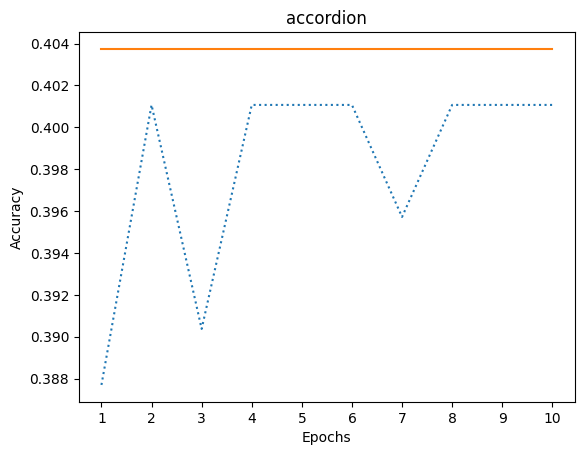

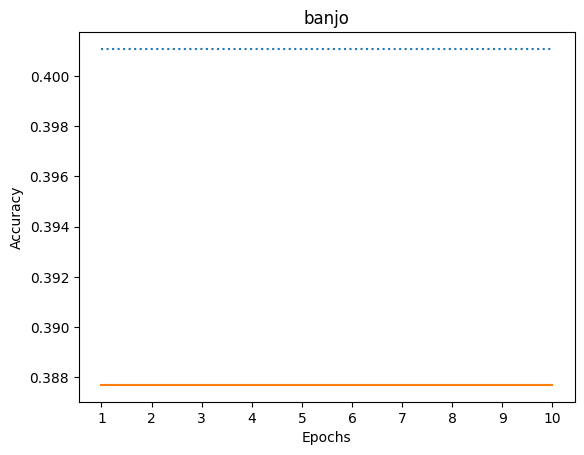

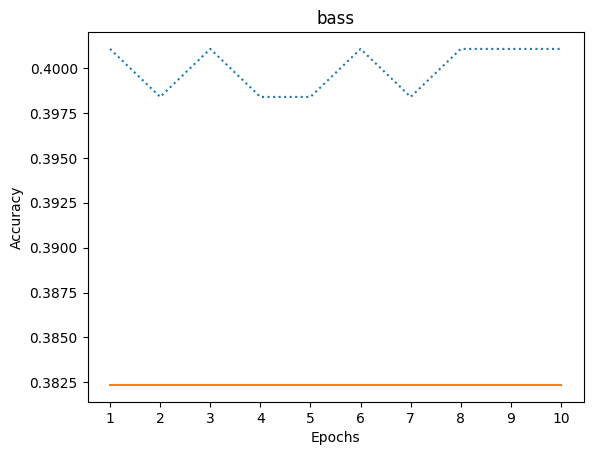

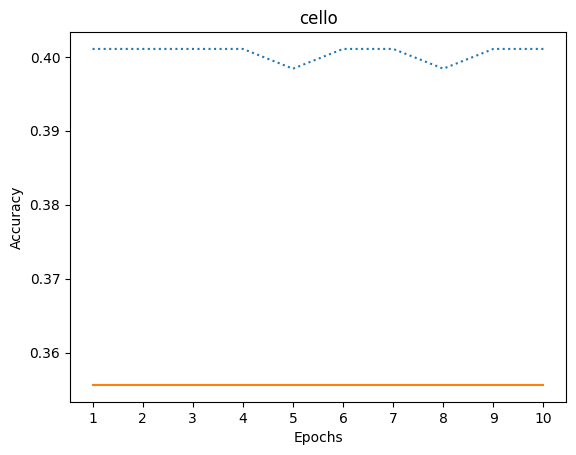

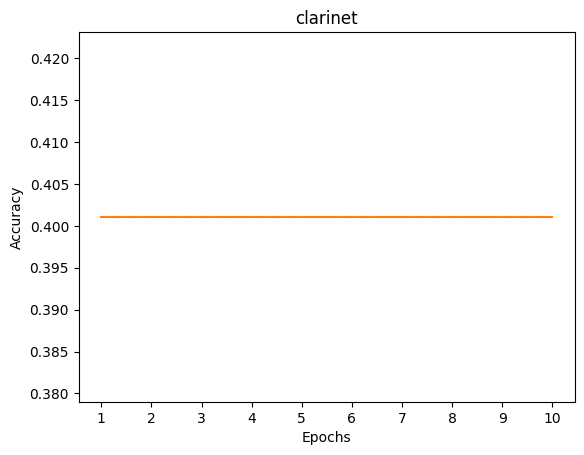

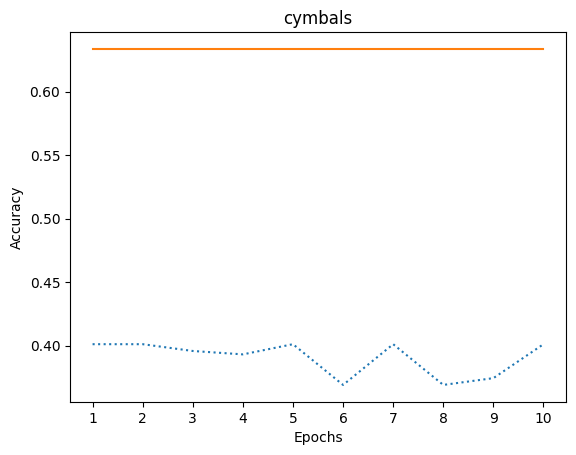

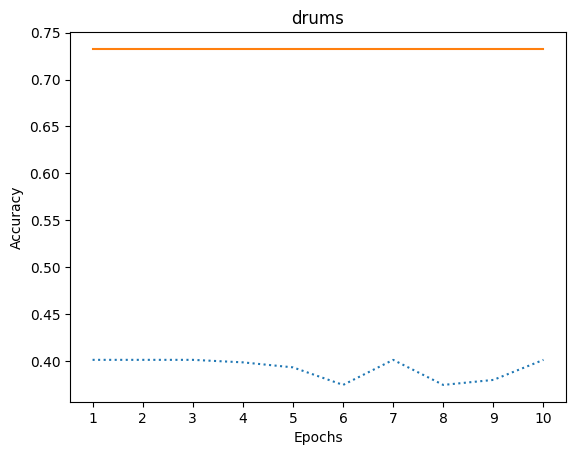

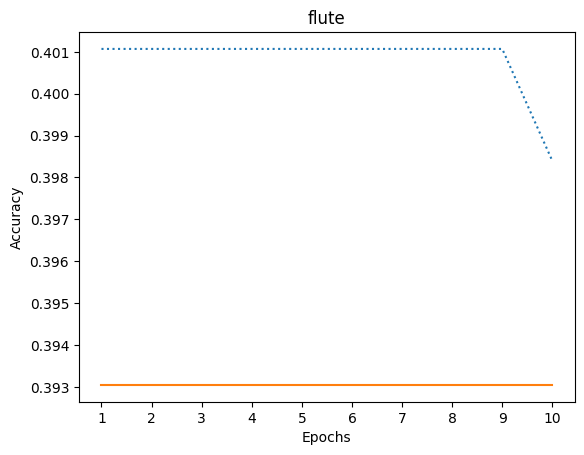

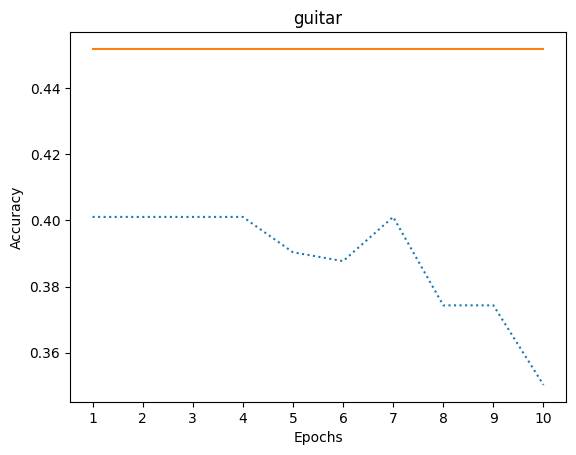

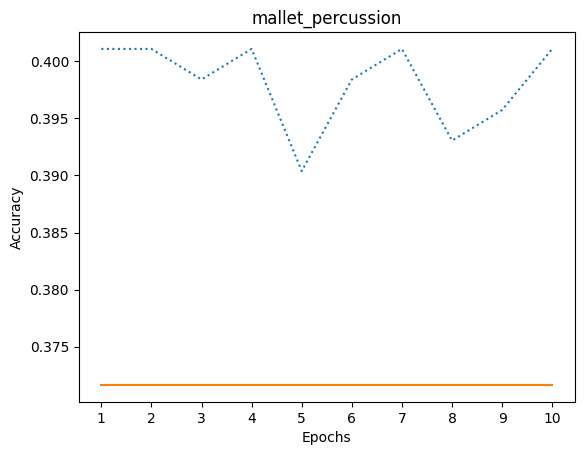

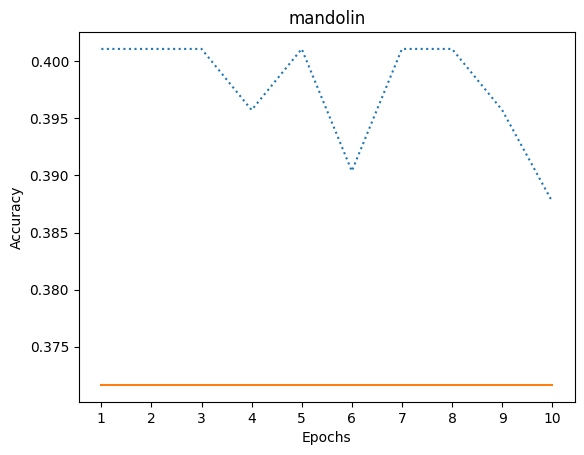

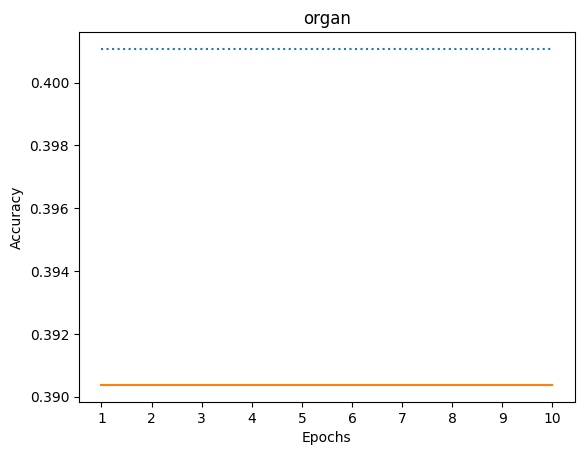

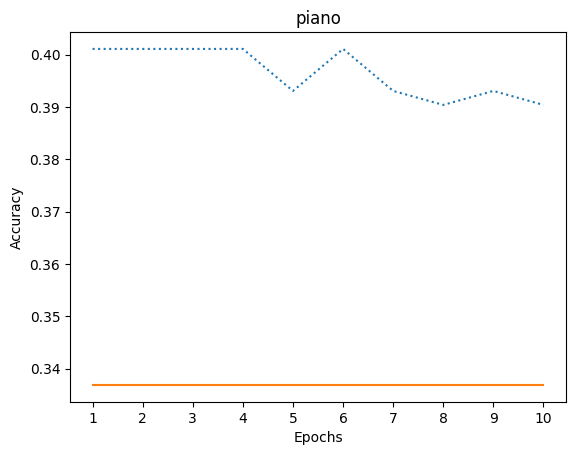

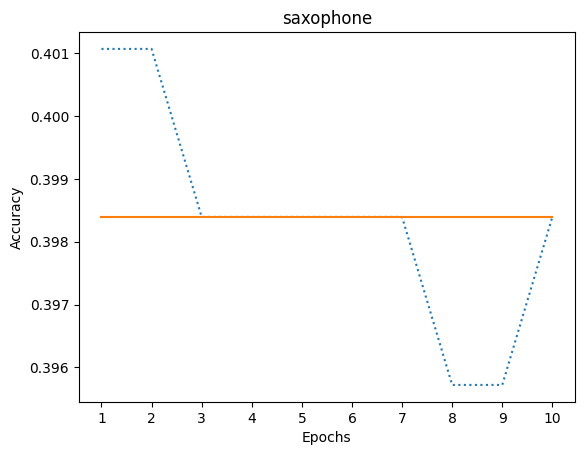

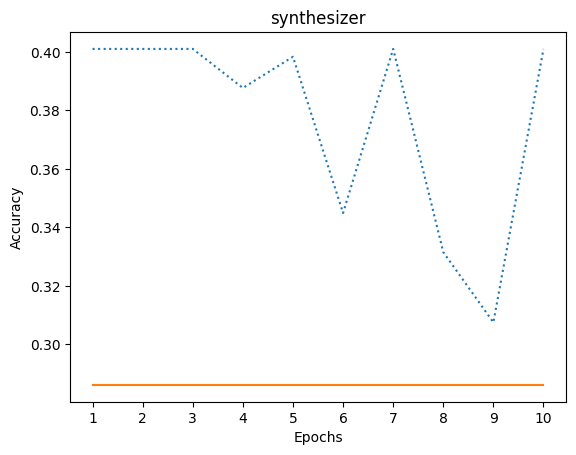

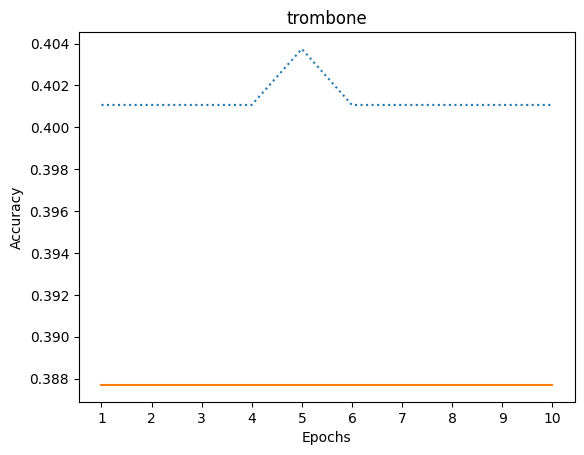

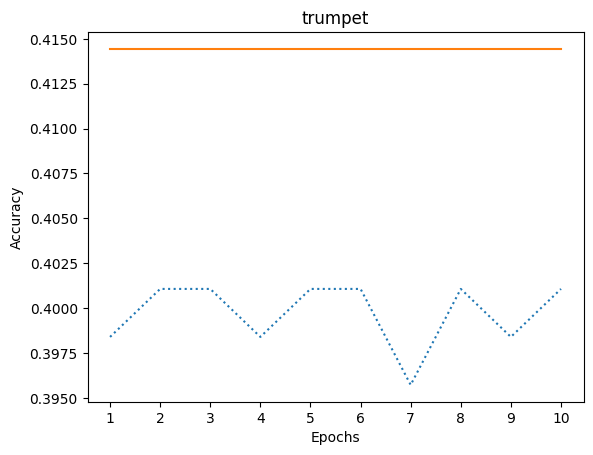

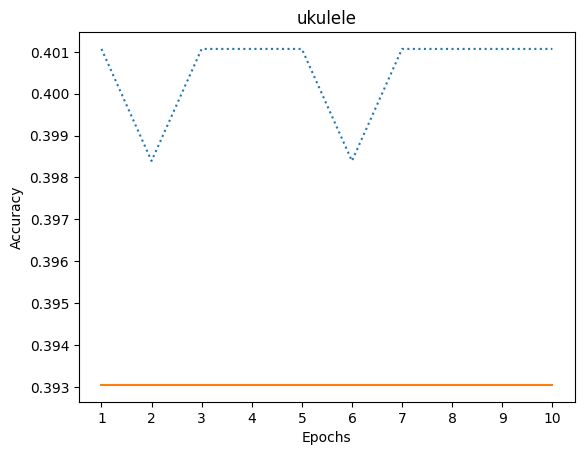

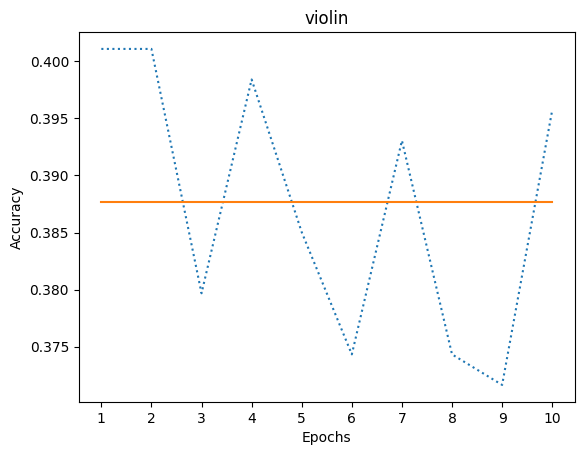

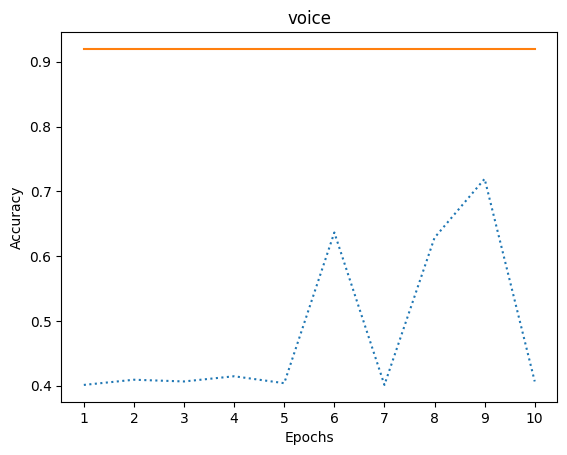

In [30]:
for i in class_map:
    plt.plot(accuracies_over_time[i], linestyle='dotted')
    plt.plot(ctrl_accuracies[i])
    plt.xlabel("Epochs")
    plt.xticks(np.arange(len(accuracies_over_time[i])), np.arange(1, len(accuracies_over_time[i])+1))
    plt.ylabel("Accuracy")
    plt.title(i)
    plt.show()

In [32]:
# Plot average accuracy across instruments
partial = []
control = []

for n in range(EPOCHS):
    t = [accuracies_over_time[i][n] for i in accuracies_over_time]   # isolates the indices
    b = [ctrl_accuracies[i][n] for i in ctrl_accuracies]   # isolates the indices
    partial.append(np.average(t))
    control.append(np.average(b))

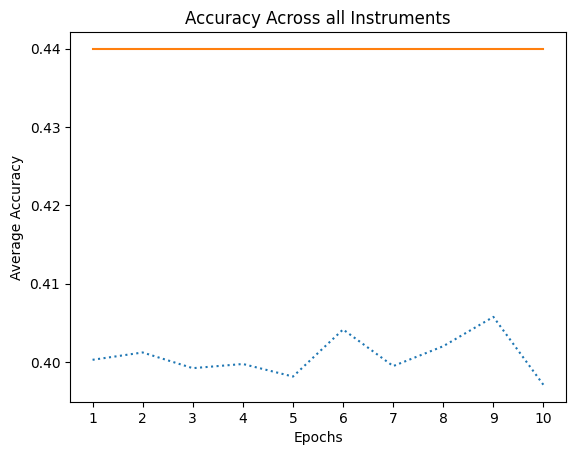

In [33]:
plt.plot(partial, linestyle='dotted')
plt.plot(control)
plt.xlabel("Epochs")
plt.xticks(np.arange(len(accuracies_over_time[i])), np.arange(1, len(accuracies_over_time[i])+1))
plt.ylabel("Average Accuracy")
plt.title("Accuracy Across all Instruments")
plt.show()